In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import re
from collections import Counter
import string
import pickle
from processing import *

In [2]:
data=pd.read_csv(PATH+'vehicles.csv')

In [3]:
cars=data[['year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'drive', 'size', 'type', 'paint_color','state', 'lat', 'long','price']]

In [4]:
cars.head()

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,price
0,2000.0,gmc,new sierra 1500,excellent,8 cylinders,gas,167783.0,clean,automatic,4wd,NaN,NaN,red,mn,46.8433,-92.2550,6995
1,2013.0,hyundai,sonata,excellent,4 cylinders,gas,90821.0,clean,automatic,fwd,NaN,NaN,grey,mn,46.9074,-92.4638,8750
2,2013.0,toyota,prius,good,4 cylinders,hybrid,92800.0,clean,automatic,fwd,NaN,NaN,blue,ct,41.1770,-73.1336,10900
3,2003.0,mitsubishi,lancer,good,4 cylinders,gas,NaN,clean,manual,4wd,mid-size,sedan,grey,nm,35.1868,-106.6650,12500
4,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,diesel,254217.0,clean,automatic,4wd,full-size,truck,white,mn,45.6836,-92.9648,16995


# EDA

In [5]:
cars.shape

(423857, 17)

In [6]:
cars.isnull().sum()/(cars.shape[0])*100

year            22.440115
manufacturer    26.097245
model           23.232600
condition       58.306929
cylinders       53.361865
fuel            22.800850
odometer        36.161252
title_status    22.672269
transmission    22.600075
drive           45.472412
size            75.787353
type            43.104160
paint_color     47.575951
state            0.000000
lat             23.463810
long            23.463810
price            0.000000
dtype: float64

In [7]:
cars.describe()

,year,odometer,lat,long,price
count,328743.000000,2.705850e+05,324404.000000,324404.000000,4.238570e+05
mean,2009.827358,9.942578e+04,38.731429,-93.949367,5.779437e+04
std,10.135809,1.204833e+05,5.902977,17.930566,1.002581e+07
min,1900.000000,0.000000e+00,-80.386400,-161.394000,0.000000e+00
25%,2007.000000,4.432400e+04,35.054500,-106.678000,4.499000e+03
50%,2012.000000,9.174900e+04,39.366900,-88.009900,9.995000e+03
75%,2016.000000,1.372370e+05,42.517075,-80.832500,1.899500e+04
max,2021.000000,1.000000e+07,80.383400,115.524000,3.808256e+09


# Geo features

In [8]:
price_in_states=cars[['state','price']]

In [9]:
lower_limit=np.quantile(price_in_states['price'],0.1)
upper_limit=np.quantile(price_in_states['price'],0.9)
data_to_plot=price_in_states[(price_in_states['price']>lower_limit)&(price_in_states['price']<upper_limit)]

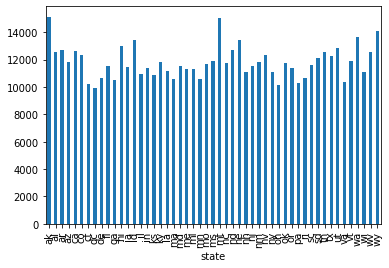

In [10]:
data_to_plot.groupby(['state'])['price'].mean().plot(kind='bar')

Therefore, location seems not a significant feature for car price, so drop all geo features

In [11]:
cars.drop(['state','lat','long'],axis=1,inplace=True)

In [12]:
cars.head()

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price
0,2000.0,gmc,new sierra 1500,excellent,8 cylinders,gas,167783.0,clean,automatic,4wd,NaN,NaN,red,6995
1,2013.0,hyundai,sonata,excellent,4 cylinders,gas,90821.0,clean,automatic,fwd,NaN,NaN,grey,8750
2,2013.0,toyota,prius,good,4 cylinders,hybrid,92800.0,clean,automatic,fwd,NaN,NaN,blue,10900
3,2003.0,mitsubishi,lancer,good,4 cylinders,gas,NaN,clean,manual,4wd,mid-size,sedan,grey,12500
4,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,diesel,254217.0,clean,automatic,4wd,full-size,truck,white,16995


### Year of car <--> mileage

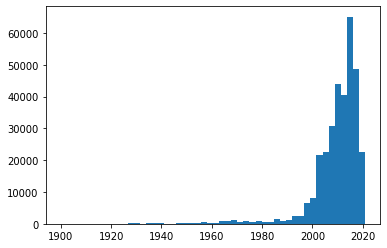

In [13]:
plt.hist(cars['year'],bins=50)
plt.show()

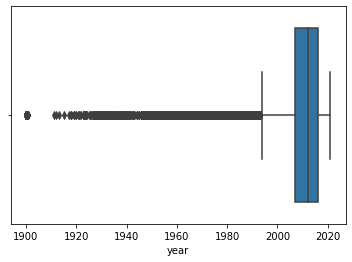

In [14]:
sns.boxplot(cars['year'],orient='h')

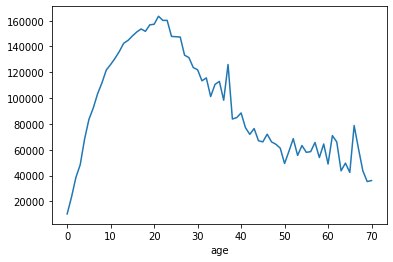

In [15]:
cars['age']=cars['year'].apply(car_age)
cars['odometer']=cars['odometer'].apply(meters_outlier)
cars.groupby(['age'])['odometer'].mean().plot()
plt.show()

In [16]:
age_meter=cars.groupby('age')['odometer'].mean().to_dict()
#age_meter=pickle.load(open(PATH+'age_meter_dict','rb'))

In [17]:
cars.isnull().sum()

year             95114
manufacturer    110615
model            98473
condition       247138
cylinders       226178
fuel             96643
odometer        153272
title_status     96098
transmission     95792
drive           192738
size            321230
type            182700
paint_color     201654
price                0
age              95114
dtype: int64

In [18]:
def rm_rows(cars):
    cars=cars[~cars['year'].isnull()]
    cars=cars[~((cars['manufacturer'].isnull())&(cars['model'].isnull()))]
    print('removed rows lack of information')
    cars=cars[~(cars['price']==0)]
    print ('removed irreasonable rows which price==0')
    return cars
    
cars=rm_rows(cars)

removed rows lack of information
removed irreasonable rows which price==0


In [19]:
cars.isnull().sum()

year                 0
manufacturer     14256
model             3900
condition       134063
cylinders       117397
fuel              1969
odometer         52696
title_status      1418
transmission      1266
drive            89301
size            206614
type             82330
paint_color      96296
price                0
age                  0
dtype: int64

In [20]:
# fill odometer null
cars=Transformer(outlier_age_meters).fit_transform(cars)

In [21]:
cars.isnull().sum()

year                 0
manufacturer     14256
model             3900
condition       134063
cylinders       117397
fuel              1969
odometer             0
title_status      1418
transmission      1266
drive            89301
size            206614
type             82330
paint_color      96296
price                0
age                  0
dtype: int64

### Manufacturer <--> Model

In [22]:
len(cars['manufacturer'].value_counts())

43

In [23]:
cars.isnull().sum()

year                 0
manufacturer     14256
model             3900
condition       134063
cylinders       117397
fuel              1969
odometer             0
title_status      1418
transmission      1266
drive            89301
size            206614
type             82330
paint_color      96296
price                0
age                  0
dtype: int64

All rows are having either manufacturer or model, or both

#### Fill NA Model

In [24]:
# manufacturer is not null, model is null
cars[(~cars['manufacturer'].isnull())&(cars['model'].isnull())]

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price,age
32,2018.0,subaru,NaN,NaN,NaN,gas,38411.233851,clean,automatic,NaN,NaN,NaN,NaN,13995,2.0
182,2005.0,chevrolet,NaN,good,6 cylinders,gas,148158.873175,clean,automatic,4wd,mid-size,SUV,custom,2150,15.0
543,2015.0,volvo,NaN,NaN,NaN,diesel,500000.000000,clean,automatic,NaN,NaN,NaN,white,30000,5.0
548,2004.0,buick,NaN,excellent,6 cylinders,gas,299.000000,clean,automatic,fwd,compact,NaN,NaN,2000,16.0
694,1972.0,chevrolet,NaN,good,NaN,gas,64245.346821,clean,automatic,NaN,NaN,pickup,NaN,17000,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423264,1948.0,ford,NaN,good,8 cylinders,gas,15715.000000,clean,manual,rwd,full-size,coupe,custom,13000,70.0
423296,1968.0,ford,NaN,NaN,NaN,gas,68590.546763,clean,manual,NaN,NaN,NaN,NaN,5000,52.0
423433,1969.0,chevrolet,NaN,good,NaN,gas,58760.484472,clean,automatic,NaN,NaN,NaN,NaN,14500,51.0
423576,2001.0,ford,NaN,NaN,NaN,gas,156786.857283,clean,automatic,NaN,NaN,NaN,NaN,2500,19.0


In [25]:
def get_default_model(cars):
    dict=pd.DataFrame(cars.groupby('manufacturer')['model'].apply(list))['model'].to_dict()

    res_dict={}
    for car in list(dict.keys()):
        d=list(filter(lambda a: str(a) != 'nan', dict[car]))
        res_dict[car]=Counter(d).most_common()
        if res_dict[car]==[]:
            res_dict[car]=''
        else:
            res_dict[car]=res_dict[car][0][0]
    return res_dict


In [26]:
default_model_dict=get_default_model(cars)

In [27]:
#pickle.dump(default_model_dict,open('default_model_by_make.txt','wb')) --> processing.py

In [28]:
def fill_default_model(df):
  lst=[]
  for car in df['manufacturer']:
    if car==np.nan:
      lst.append(default_model_dict[car])
    else:
      lst.append('')
  df['default_model']=lst
  df['model'][df['model']=='nan']=np.nan
  df['model'].fillna(df['default_model'],inplace=True)
  return df

cars=fill_default_model(cars)

In [29]:
cars[cars['model'].isnull()]

,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price,age,default_model


In [30]:
cars.isnull().sum()

year                  0
manufacturer      14256
model                 0
condition        134063
cylinders        117397
fuel               1969
odometer              0
title_status       1418
transmission       1266
drive             89301
size             206614
type              82330
paint_color       96296
price                 0
age                   0
default_model         0
dtype: int64

#### Fill NA Manufacturers

In [31]:
def revise_manu(cars):
    ind=[] 
    manufacturer=[]
    drops=[]
    for idx in cars[cars['manufacturer'].isnull()].index:
        cars['model'][idx]=' '.join(re.sub(r'[19,20]\d+','',cars['model'][idx]).split())
        if re.search(r'[Ff]\W?\d+',cars['model'][idx]) or re.findall(r'superduty|mstang|ford',cars['model'][idx].lower()): 
            ind.append(idx)
            manufacturer.append('ford')
            #model.append(re.findall(r'[Ff]\W?\d+',cars['model'][idx]))
        elif re.findall(r'maserati',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('maserati')
        elif re.findall(r'corvette|cheverolet|camaro|chverolet|chryler|cheverolt',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('cheverolet')
        elif re.findall(r'acterra|sterling|sterling acterra',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('sterling acterra')
        elif re.findall(r'cruiser|chrysler|chryler',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('chrysler')
        elif re.findall(r'volkswagon|volkwagen|wagen|passet|jetta|tiguan',cars['model'][idx].lower()):
            ind.append(idx) 
            manufacturer.append('volkswagen')
        elif re.findall(r'suzuki',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('suzuki')
        elif re.findall(r'porsche|speedster|boxster|caddy|cts|turbo',cars['model'][idx].lower()) :
            ind.append(idx)
            manufacturer.append('porsche')
        elif re.findall(r'mini|cooper|bmw|mwb|bwm|x5|x3|x1|335|320',cars['model'][idx].lower()) :
            ind.append(idx)
            manufacturer.append('bmw')
        elif re.findall(r'international|freightliner|truck|kaiser|cascadia',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('truck')
        elif re.findall(r'mazda',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('mazda')
        elif re.findall(r'infinite|infiniti',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('infiniti')
        elif re.findall(r'mclaren',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('mclaren')
        elif re.findall(r'rollsroyce',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('rollsroyce')
        elif re.findall(r'benz|mercedes|smart|mb|ml\d+|cls\d+|sls\d+|sl\d+|cla\d+',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('mercedes-benz')
        elif re.findall(r'huyndai|sonata|hyndai',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('hyundai')
        elif re.findall(r'isuzu',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('isuzu')
        elif re.findall(r'bentley|bently',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('bentley')
        elif re.findall(r'lamborghini',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('lamborghini')
        elif re.findall(r'jeep',cars['model'][idx].lower()) or re.findall(r'hummer',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('jeep')
        elif re.findall(r'scion',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('scion')
        elif re.findall(r'accord|honda',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('honda')
        elif re.findall(r'nissian|rouge|rogue|altima',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('nissan')
        elif re.findall(r'toyota|tacoma|corolla|toyo\W|camry',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('toyota')
        elif re.findall(r'caravan|journey',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('dodge')
        elif re.findall(r'triumph|spitfire|ply|plymouth|spartan',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('others')
        elif re.findall(r'encore|buick',cars['model'][idx].lower()):
            ind.append(idx)
            manufacturer.append('buick')
        elif re.findall(r'nan|any|all',cars['model'][idx].lower()):
            cars.drop(idx,axis=0,inplace=True)
        try:
            if re.findall(r'truck|pickup',cars['type'][idx].lower()):
                ind.append(idx)
                manufacturer.append('truck')
        except:
            pass
        else:
            drops.append(idx)
    for i,idx in enumerate(ind):
        cars['manufacturer'][idx]=manufacturer[i]
    cars.drop(drops,axis=0,inplace=True)
    print (f'revised {len(ind)} car\'s manufacturers.')
    print (f'droped {len(drops)} cars.')
    cars=cars[~cars['manufacturer'].isnull()]
    print (f'left {cars.shape[0]} cars.')
    return cars

In [32]:
# revise manufacturers
def revise_manufacturers(cars):
  cars[cars['manufacturer']=='CHEVEROLET']['manufacturer']='CHEVROLET'
  cars[cars['manufacturer']=='HUYNDAI']['manufacturer']='HYUNDAI'
  cars[cars['manufacturer']=='NISSIAN']['manufacturer']='NISSAN'
  cars[cars['manufacturer']=='PORCHE']['manufacturer']='PORSCHE'
  cars[cars['manufacturer']=='VOLKSWAGON']['manufacturer']='VOLKSWAGEN'
  return cars

In [33]:
cars['model']=cars['model'].astype(str).apply(make_lower)
cars=revise_manu(cars)
cars['manufacturer']=cars['manufacturer'].apply(rm_punctuation)
cars['model']=cars['model'].apply(rm_punctuation)
cars=revise_manufacturers(cars)

revised 10282 car's manufacturers.
droped 8539 cars.
left 289261 cars.


In [34]:
cars.isnull().sum()

year                  0
manufacturer          0
model                 0
condition        129917
cylinders        112779
fuel               1849
odometer              0
title_status       1390
transmission       1144
drive             85088
size             199588
type              79294
paint_color       92451
price                 0
age                   0
default_model         0
dtype: int64

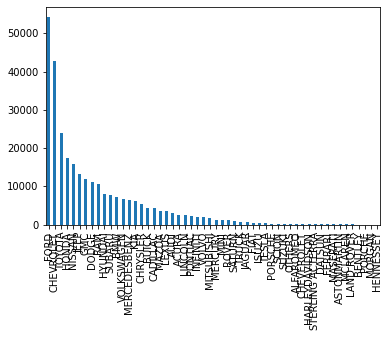

In [35]:
cars['manufacturer'].value_counts().plot(kind='bar')

In [36]:
len(cars['manufacturer'].value_counts())

54

#### Generate list of model by make

In [37]:
def models_of_make(cars):
    dict=pd.DataFrame(cars.groupby('manufacturer')['model'].apply(list))['model'].to_dict()

    res_dict={}
    for car in list(dict.keys()):
        d=list(filter(lambda a: str(a) != 'nan', dict[car]))
        if len(d)>=1000:
            model_lst=Counter(d).most_common()
            models_of_make=[]
            for m in model_lst:
                if m[1]>5:
                    models_of_make.append(m[0])
                    d=sorted(list(set(models_of_make)))
                else:
                    pass
            res_dict[car]=d
        else:
            d=sorted(list(set(d)))
            res_dict[car]=d
            if res_dict[car]==[]:
                res_dict[car]=''
            else:
                res_dict[car]=res_dict[car]
    return res_dict

In [38]:
# models_of_make_dict -- streamlit.app
defaults_model_make_dict=models_of_make(cars)

In [39]:
# generate list of make -- streamlit.app
make_list=list(defaults_model_make_dict.keys())
# pickle.dump(make_list,open(PATH+'list_of_make.txt','wb'))

## Other features




### Get default values for each feature
to fill na

In [41]:
def get_default(cars,col):
    dropna_df=cars.loc[cars[col].index]
    df=pd.DataFrame(dropna_df.groupby(['manufacturer','model'])[col].apply(list))

    dict=df[col].to_dict()

    res_dict={}
    for car in list(dict.keys()):
        d=list(filter(lambda a: str(a) != 'nan', dict[car]))
        res_dict[car]=Counter(d).most_common()
        if res_dict[car]==[]:
            res_dict[car]=np.nan
        else:
            res_dict[car]=res_dict[car][0][0]
    return res_dict

In [42]:
default_drive_dict=get_default(cars,'drive')
default_cylinders_dict=get_default(cars,'cylinders')
default_fuel_dict=get_default(cars,'fuel')
default_transmission_dict=get_default(cars,'transmission')
default_size_dict=get_default(cars,'size')
default_type_dict=get_default(cars,'type')
default_paint_color_dict=get_default(cars,'paint_color')
default_title_status_dict=get_default(cars,'title_status')

In [43]:
def fill_na_by_default(df):
    #drive
    df['default_drive']=[default_drive_dict[car] for car in df['car_model']]
    #cylinders
    df['default_cylinders']=[default_cylinders_dict[car] for car in df['car_model']]
    #fuel
    df['default_fuel']=[default_fuel_dict[car] for car in df['car_model']]
    #transmission
    df['default_transmission']=[default_transmission_dict[car] for car in df['car_model']]
    # size
    df['default_size']=[default_size_dict[car] for car in df['car_model']]
    # type
    df['default_type']=[default_type_dict[car] for car in df['car_model']]
    # paint_color
    df['default_paint_color']=[default_paint_color_dict[car] for car in df['car_model']]
    # title_status
    df['default_title_status']=[default_title_status_dict[car] for car in df['car_model']]

    df['drive'].fillna(df['default_drive'],inplace=True)
    df['cylinders'].fillna(df['default_cylinders'],inplace=True)
    df['fuel'].fillna(df['default_fuel'],inplace=True)
    ['car_model']
    df['transmission'].fillna(df['default_transmission'],inplace=True)
    df['size'].fillna(df['default_size'],inplace=True)
    df['type'].fillna(df['default_type'],inplace=True)
    df['paint_color'].fillna(df['default_paint_color'],inplace=True)
    df['title_status'].fillna(df['default_title_status'],inplace=True)
    return df

In [44]:
cars.isnull().sum()

year                  0
manufacturer          0
model                 0
condition        129917
cylinders        112779
fuel               1849
odometer              0
title_status       1390
transmission       1144
drive             85088
size             199588
type              79294
paint_color       92451
price                 0
age                   0
default_model         0
dtype: int64

In [45]:
cars['car_model'] = list(zip(cars.manufacturer, cars.model))
cars=fill_na_by_default(cars)

In [46]:
cars.isnull().sum()

year                         0
manufacturer                 0
model                        0
condition               129917
cylinders                14834
fuel                       982
odometer                     0
title_status               359
transmission                76
drive                     7426
size                     33271
type                      8436
paint_color               9194
price                        0
age                          0
default_model                0
car_model                    0
default_drive             7426
default_cylinders        14834
default_fuel               982
default_transmission        76
default_size             33271
default_type              8436
default_paint_color       9194
default_title_status       359
dtype: int64

In [47]:
# fill other features by mode of each
cars=fill_freq(cars)

In [48]:
cars.isnull().sum()

year                        0
manufacturer                0
model                       0
condition                   0
cylinders                   0
fuel                        0
odometer                    0
title_status                0
transmission                0
drive                       0
size                        0
type                        0
paint_color                 0
price                       0
age                         0
default_model               0
car_model                   0
default_drive            7426
default_cylinders       14834
default_fuel              982
default_transmission       76
default_size            33271
default_type             8436
default_paint_color      9194
default_title_status      359
dtype: int64

In [49]:
pickle.dump(default_cylinders_dict,open(PATH+'default_cylinders.txt','wb'))

pickle.dump(default_fuel_dict,open(PATH+'default_fuel.txt','wb'))

pickle.dump(default_size_dict,open(PATH+'default_size.txt','wb'))

pickle.dump(default_transmission_dict,open(PATH+'default_transmission.txt','wb'))

pickle.dump(default_drive_dict,open(PATH+'default_drive.txt','wb'))

pickle.dump(default_type_dict,open(PATH+'default_type.txt','wb'))

pickle.dump(default_paint_color_dict,open(PATH+'default_paint_color.txt','wb'))

pickle.dump(default_title_status_dict,open(PATH+'default_title_status.txt','wb'))

### Get default list of each feature

In [50]:
drive_list=pickle.load(open(PATH+'list_drive.txt','rb'))
cylinder_list=pickle.load(open(PATH+'list_cylinder.txt','rb'))
fuel_list=pickle.load(open(PATH+'list_fuel.txt','rb'))
transmission_list=pickle.load(open(PATH+'list_transmission.txt','rb'))
size_list=pickle.load(open(PATH+'list_size.txt','rb'))
type_list=pickle.load(open(PATH+'list_type.txt','rb'))

In [51]:
col_dict={
    'drive':drive_list,
    'cylinders':cylinder_list,
    'fuel':fuel_list,
    'transmission':transmission_list,
    'size':size_list,
    'type':type_list
}

In [52]:
def get_default_lst(cars,col):
    dict=pd.DataFrame(cars.groupby(['manufacturer','model'])[col].apply(list)).to_dict()[col]

    res_dict={}
    for car in list(dict.keys()):
        d=Counter(list(filter(lambda a: str(a) != 'nan', dict[car]))).most_common()
        d=[m[0] for m in d]
        if len(d)<=1:
            d=col_dict[col]
        res_dict[car]=d
    return res_dict

In [53]:
default_drive_by_car=get_default_lst(cars,'drive')
default_cylinders_by_car=get_default_lst(cars,'cylinders')
default_size_by_car=get_default_lst(cars,'size')
default_type_by_car=get_default_lst(cars,'type')
default_fuel_by_car=get_default_lst(cars,'fuel')
default_transmission_by_car=get_default_lst(cars,'transmission')

In [54]:
for k in default_size_by_car.keys():
  if default_size_by_car[k]==[]:
    print (k)

In [55]:
pickle.dump(default_drive_by_car,open(PATH+'default_drive_by_car.txt','wb'))

pickle.dump(default_cylinders_by_car,open(PATH+'default_cylinders_by_car.txt','wb'))

pickle.dump(default_size_by_car,open(PATH+'default_size_by_car.txt','wb'))

pickle.dump(default_type_by_car,open(PATH+'default_type_by_car.txt','wb'))

pickle.dump(default_fuel_by_car,open(PATH+'default_fuel_by_car.txt','wb'))

pickle.dump(default_transmission_by_car,open(PATH+'default_transmission_by_car.txt','wb'))

pickle.dump(default_paint_color_dict,open(PATH+'default_paint_color.txt','wb'))

pickle.dump(default_title_status_dict,open(PATH+'default_title_status.txt','wb'))